In [4]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

#path = "examples/data/L2_0-20000-006735_A20210908.nc"
path = "examples/data/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

#basic corrections
profiles.extrapolate_below(z=300, inplace=True)
profiles.desaturate_below(z=4000, inplace=True)

In [36]:
self = profiles
time = self.data.time.data
altitude = self.data.altitude.data

datetime = np.datetime64('2021-09-09T21:20:00')
datetime = np.datetime64('2021-09-09T10:25:00')
datetime = np.datetime64('2021-09-09T22:15:00')
datetime = np.datetime64('2021-09-09T14:20:00')
#datetime = np.datetime64('2021-09-09T00:10:00')

itime = self._get_itime(datetime)
data = self.data.attenuated_backscatter_0.data[itime,:]

zmin=300
thr_noise=4.0
thr_clouds=4.0
min_snr=0.

In [37]:
#data: 1D range corrected signal (rcs)
#zmin: altitude AGL, in m, above which we detect clouds
#thr_noise: threshold used in the test to determine if a couple (base,peak) is significant: data[peak(z)] - data[base(z)] >= thr_noise * noise(z)
#thr_clouds: threshold used to discriminate aerosol from clouds: data[peak(z)] / data[base(z)] >= thr_clouds
#min_snr: minimum SNR required at the clouds peak value to consider the cloud as valid. Defaults to 2.

from scipy import signal
from scipy.ndimage.filters import uniform_filter1d

#some useful functions:
def get_indexes(mask):
    #mask: list of Bool
    #returns a list indexes where the mask is True
    return [i for i, x in enumerate(mask) if x]

def _get_all_indexes(bases, peaks, tops=[]):
    #get True indexes of bases, peaks and tops, based on masks
    i_bases = get_indexes(bases)
    i_peaks = get_indexes(peaks)
    i_tops = get_indexes(tops)
    return i_bases, i_peaks, i_tops

def make_mask(length, indexes_where_True):
    #length: int: length of the mask
    #indexes_where_true: list
    mask = np.asarray([False for x in np.ones(length)])
    mask[indexes_where_True] = len(indexes_where_True)*[True]
    return mask

def _make_all_masks(data, i_bases, i_peaks, i_tops=[]):
    #return masks for bases, peaks and tops based on input indexes
    bases = make_mask(len(data), i_bases)
    peaks = make_mask(len(data), i_peaks)
    tops = make_mask(len(data), i_tops)
    return bases, peaks, tops


def _snr_at_iz(array, iz, step):
    #calculates the snr from array at iz around step points
    gates = np.arange(iz-step,iz+step)
    indexes = [i for i in gates if i>0 and i<len(array)]
    mean = np.nanmean(array[indexes])
    std = np.nanstd(array[indexes], ddof=0)
    if std!=0:
        return mean/std
    else:
        return 0

def _merge_layers(data, i_bases, i_peaks, i_tops):
    #merge layers depending on the altitude of the bases and the tops
    remove_mode = True
    while remove_mode:
        remove_bases, remove_peaks, remove_tops = [], [], []
        for i in range(len(i_bases)-1):
            #filters based on the index
            if i_bases[i+1]<=i_tops[i]: 
                remove_bases.append(i_bases[i+1])
                #remove the weakest peak
                imin = np.argmin([data[i_peaks[i]],data[i_peaks[i+1]]])
                remove_peaks.append(i_peaks[i+imin])
                #remove lowest top
                imin = np.argmin([i_tops[i],i_tops[i+1]])
                remove_tops.append(i_tops[i+imin])
                #start again from the bottom
                break

        i_bases = [i for i in i_bases if i not in remove_bases]
        i_peaks = [i for i in i_peaks if i not in remove_peaks]
        i_tops = [i for i in i_tops if i not in remove_tops]
        if len(remove_bases)==0:
            remove_mode = False

    return i_bases, i_peaks, i_tops


def _find_tops(data, i_bases, i_peaks):
    #function that finds the top of the layers by identifying the first value above thepeak for which the signal is lower than the base
    #if no top is found, the layer is removed
    #retruns lists of indexes of the bases, peaks and tops
    tops = np.asarray([False for x in np.ones(len(data))])
    # conditions: look for bases above i_peaks[i], and data[top[i]] <= data[base[i]]
    
    header = ['i_base','base','data(base)','i_top','top','data(top)']
    print(*header, sep='\t')
    i_tops = []
    for i in range(len(i_bases)):
        mask_value = np.asarray([True if data[j]<data[i_bases[i]] else False for j in range(len(data))])
        mask_altitude = np.asarray([True if j>i_peaks[i] else False for j in range(len(data))])
        #the top is the first value that corresponds to the intersection of the two masks
        cross_mask = np.logical_and(mask_value, mask_altitude)
        i_cross_mask = get_indexes(cross_mask)
        if len(i_cross_mask)>0:
            if tops[i_cross_mask[0]]:
                #print('top already found. remove current layer')
                bases[i_bases[i]] = False
                peaks[i_peaks[i]] = False    
            else:
                row = [i_bases[i], 30*i_bases[i], data[i_bases[i]], i_cross_mask[0], 30*i_cross_mask[0], data[i_cross_mask[0]]]
                print(*row, sep='\t')
                tops[i_cross_mask[0]] = True
                i_tops.append(i_cross_mask[0])
        else:
            #print('no top found for base',i_bases[i])
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False
    #it is important to keep the tops in the same order, so not to use get_indexes() function here
    return get_indexes(bases), get_indexes(peaks), i_tops

def _find_tops2(data, i_bases, i_peaks):
    #function that finds the top of the layers by identifying the positive gradient above the peak
    tops = np.asarray([False for x in np.ones(len(data))])
    i_tops = []

    gradient = np.gradient(data)
    for i in range(len(i_bases)):
        mask_value = np.asarray([True if gradient[j]>0 else False for j in range(len(data))])
        mask_altitude = np.asarray([True if j>i_peaks[i] else False for j in range(len(data))])
        #the top is the first value that corresponds to the intersection of the two masks
        cross_mask = np.logical_and(mask_value, mask_altitude)
        i_cross_mask = get_indexes(cross_mask)
        if len(i_cross_mask)>0:
            if tops[i_cross_mask[0]]:
                #print('top already found. remove current layer')
                bases[i_bases[i]] = False
                peaks[i_peaks[i]] = False    
            else:
                row = [i_bases[i], 30*i_bases[i], data[i_bases[i]], i_cross_mask[0], 30*i_cross_mask[0], data[i_cross_mask[0]]]
                print(*row, sep='\t')
                tops[i_cross_mask[0]] = True
                i_tops.append(i_cross_mask[0])
        else:
            #print('no top found for base',i_bases[i])
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False
    #it is important to keep the tops in the same order, so not to use get_indexes() function here
    return get_indexes(bases), get_indexes(peaks), i_tops


In [38]:
#0. rolling average
avg_data = uniform_filter1d(data, size=10)


#1. first derivative
gradient = np.gradient(avg_data)


#2. identifies peaks and base by checking the sign changes of the derivative
sign_changes = np.diff(np.sign(gradient), append=0)
all_bases = sign_changes==2
all_peaks = sign_changes==-2
#limit to bases above zmin
imin = self._get_index_from_altitude_AGL(zmin)
all_bases[0:imin] = [False for i in range(len(all_bases[0:imin]))]
all_peaks[0:imin] = [False for i in range(len(all_peaks[0:imin]))]
#get indexes
i_bases = get_indexes(all_bases)
i_peaks = get_indexes(all_peaks)


#3. the signal should start with a base
if i_bases[0]>i_peaks[0] and i_peaks[0]>=1:
    #set base as the minimum between peak and n gates under
    gates = np.arange(i_peaks[0]-5,i_peaks[0])
    i_base = gates[np.argmin([data[gates[gates>=0]]])]
    if i_base>=imin:
        all_bases[i_base]=True
    else:
        all_peaks[i_peaks[0]] = False
#update indexes
i_bases = get_indexes(all_bases)
i_peaks = get_indexes(all_peaks)



#4. keeps significant couples (base,peak)
# a layer can be considered as a proper layer if the difference of signal between the peak and the base is significant (larger than the noise level)
# noise evaluation (using a high passing frequency filter)
b, a = signal.butter(1, 0.3, btype='high')
noise = signal.filtfilt(b, a, data)
#rolling average of the noise
avg_abs_noise = uniform_filter1d(abs(noise), size=100)
#make sure we have as many peaks as bases
if len(i_peaks)!=len(i_bases):
    min_len = min([len(i_peaks),len(i_bases)])
    i_peaks = i_peaks[0:min_len]
    i_bases = i_bases[0:min_len]
bases, peaks = all_bases, all_peaks
for i in range(len(i_bases)):
    data_around_peak = avg_data[i_peaks[i]]
    data_around_base = avg_data[i_bases[i]]
    if data_around_peak - data_around_base <= thr_noise * avg_abs_noise[i_bases[i]]:
        bases[i_bases[i]] = False
        peaks[i_peaks[i]] = False
#get indexes
i_bases = get_indexes(bases)
i_peaks = get_indexes(peaks)


#5. make sure we finish by a peak: remove last base if necessary
if len(i_bases)>len(i_peaks):
    bases[i_bases[-1]] = False
    i_bases.pop()


#6. find tops of clouds layers
i_bases, i_peaks, i_tops = _find_tops(avg_data, i_bases, i_peaks)


#7. merge layers: for a couple of base and peaks 1,2 if data(b2)>data(p1), then merge layers 1 and 2 by removing p1 and b2
i_bases, i_peaks, i_tops = _merge_layers(avg_data, i_bases, i_peaks, i_tops)


#8. find peaks as maximum between base and top
i_peaks = [i_bases[i]+np.argmax(data[i_bases[i]:i_tops[i]]) for i in range(len(i_bases))]
#reconstruct masks
bases, peaks, tops = _make_all_masks(data, i_bases, i_peaks, i_tops)


#9. distinction between aerosol and clouds
for i in range(len(i_bases)):
    data_around_peak = avg_data[i_peaks[i]]
    data_around_base = avg_data[i_bases[i]]
    if abs((data_around_peak - data_around_base) / data_around_base) <= thr_clouds:
        bases[i_bases[i]] = False
        peaks[i_peaks[i]] = False
        tops[i_tops[i]] = False
#get indexes
i_bases, i_peaks, i_tops = _get_all_indexes(bases, peaks, tops)

"""
#10. set base a closest index
for i, i_peak in enumerate(i_peaks):
    mask_value = np.asarray([True if gradient[j]>0 else False for j in range(len(data))])
    mask_altitude = np.asarray([True if j<i_peaks[i] else False for j in range(len(data))])
    #the top is the first value that corresponds to the intersection of the two masks
    cross_mask = np.logical_and(mask_value, mask_altitude)
    i_cross_mask = get_indexes(cross_mask)
    i_bases[i] = i_cross_mask[-1]
print(i_bases)

"""
#11. check snr at peak levels
remove_bases, remove_peaks, remove_tops = [], [], []
for i in range(len(i_peaks)):
    if _snr_at_iz(data, i_peaks[i], step=4)<min_snr:
        remove_bases.append(i_bases[i])
        remove_peaks.append(i_peaks[i])
        remove_tops.append(i_tops[i])
# remove indexes
i_bases = [i for i in i_bases if i not in remove_bases]
i_peaks = [i for i in i_peaks if i not in remove_peaks]
i_tops = [i for i in i_tops if i not in remove_tops]


#11. rebuild masks from indexes
bases, peaks, tops = _make_all_masks(data, i_bases, i_peaks, i_tops)

i_base	base	data(base)	i_top	top	data(top)
44	1320	0.12437531038394908	146	4380	0.10256037250625508
101	3030	0.2809966788552217	140	4200	0.26745991691794174
254	7620	-0.08629106130484103	309	9270	-0.08905195741169017


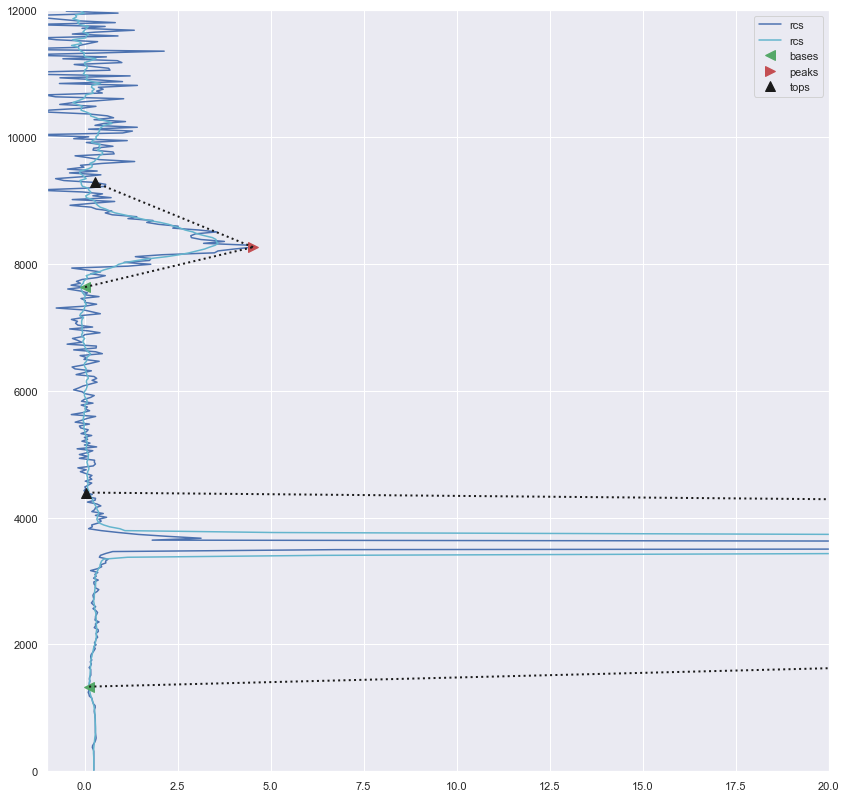

In [39]:
#some plotting
fig, ax = plt.subplots(1,1,figsize=(14,14))

ymin, ymax = 000, 12000
altitude_agl = profiles.data.altitude.data - profiles.data.station_altitude.data

#signal on the left
ax.plot(data, altitude_agl, 'b', ms=10, label='rcs')
ax.plot(avg_data, altitude_agl, 'c', ms=10, label='rcs')
#axs[0].plot(avg_abs_noise,altitude_agl,':b', ms=10, label='noise level')
#axs[0].plot(avg_abs_noise*thr_noise,altitude_agl,':b', ms=10, label='noise level * {}'.format(thr_noise))
ax.plot(data[i_bases], altitude_agl[i_bases], '<g', ms=10, label='bases')
ax.plot(data[i_peaks], altitude_agl[i_peaks], '>r', ms=10, label='peaks')
ax.plot(data[i_tops], altitude_agl[i_tops], '^k', ms=10, label='tops')

#plot lines
for i in range(len(i_peaks)):
    ax.plot([data[i_bases[i]],data[i_peaks[i]]],[altitude_agl[i_bases[i]],altitude_agl[i_peaks[i]]],':k',lw=2)
for i in range(len(i_tops)):
    ax.plot([data[i_peaks[i]],data[i_tops[i]]],[altitude_agl[i_peaks[i]],altitude_agl[i_tops[i]]],':k',lw=2)

#set axis
ax.set_ylim([ymin, ymax])
ax.set_xlim([-1,20])
ax.legend()

In [29]:
i_tops

[276]